<a href="https://colab.research.google.com/github/lephuocdat2000/DeepLearning-and-Application/blob/main/SER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np

###Extract file name and label

In [105]:
data_path = '/content/drive/MyDrive/Data Voice'
emotions=os.listdir(data_path)
filenames = []
labels = []
for emotion in emotions:
   file_names = os.listdir(os.path.join(data_path,emotion))
   for name in file_names:
     if name!='transcript': 
         filenames.append(name.split(".")[0])
         labels.append(np.float(name[0]))

labels = np.array(labels)

###Build audio vector

In [5]:
import librosa
from numpy import save
import librosa.display
import matplotlib.pyplot as plt
from numpy import load


In [7]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [160]:
audio_vectors = []
for idx,name in enumerate(filenames):
    emotion_path = os.path.join(data_path,emotions[int(labels[idx])])
    file_path = os.path.join(emotion_path,name+'.wav')
    y,sr = librosa.load(file_path, sr=44100)
    audio_vectors.append(y)



/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/cor

In [170]:
audio_vectors = np.array(audio_vectors)

In [171]:
save('audio_vectors.npy',audio_vectors)

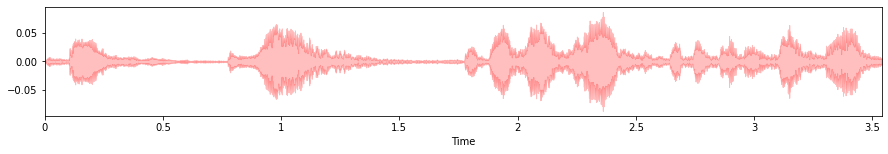

In [172]:
sr=44100 
y = audio_vectors[0]
plt.figure(figsize=(15,2))
librosa.display.waveplot(y, sr=sr, max_sr=1000, alpha=0.25, color='r')

RMSE mean = 0.00859
RMSE std dev = 0.00671


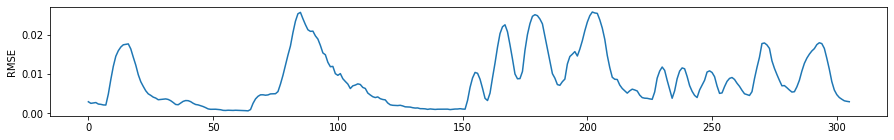

In [ ]:
rmse = librosa.feature.rms(y + 0.0001)[0]
plt.figure(figsize=(15,2))
plt.plot(rmse)
plt.ylabel('RMSE')
print('RMSE mean = {:.5f}'.format(np.mean(rmse)))
print('RMSE std dev = {:.5f}'.format(np.std(rmse)))

In [220]:
audio_vectors = load('audio_vectors.npy',allow_pickle=True)
audio_features = []
for y in audio_vectors:
  features = []
  sig_mean = np.mean(abs(y))
  features.append(sig_mean)
  features.append(np.std(y))
  rmse = librosa.feature.rms(y + 0.0001)[0]
  features.append(np.mean(rmse))  # rmse_mean
  features.append(np.std(rmse))
  silence = 0
  for e in rmse:
    if e <= 0.4 * np.mean(rmse):
        silence += 1
  silence /= float(len(rmse))
  features.append(silence)  # silence
  y_harmonic = librosa.effects.hpss(y)[0]
  features.append(np.mean(y_harmonic) * 1000)  # harmonic (scaled by 1000)
  cl = 0.45 * sig_mean
  center_clipped = []
  for s in y:
    if s >= cl: center_clipped.append(s - cl)
    elif s <= -cl: center_clipped.append(s + cl)
    elif np.abs(s) < cl: center_clipped.append(0)
  auto_corrs = librosa.core.autocorrelate(np.array(center_clipped))
  features.append(1000 * np.max(auto_corrs)/len(auto_corrs))  # auto_corr_max (scaled by 1000)
  features.append(np.std(auto_corrs))  # auto_corr_std              
  audio_features.append(features)

#Save audio_features
audio_features = np.array(audio_features)
save('audio_features.npy',audio_features)

#Split audio_feature

In [221]:
audio_features =load('audio_features.npy',allow_pickle=True)

In [222]:
from sklearn.model_selection import train_test_split
x_train_audio,x_test_audio,y_train,y_test = train_test_split(audio_features,labels,test_size=0.2,random_state=42)

Load feature

###Extract Text feature


**Define preprocessing functions for text**

In [10]:
!pip install underthesea

     |████████████████████████████████| 7.5MB 6.9MB/s 
     |████████████████████████████████| 747kB 33.9MB/s 
     |████████████████████████████████| 1.3MB 29.1MB/s 
     |████████████████████████████████| 245kB 49.0MB/s 
     |████████████████████████████████| 51kB 5.0MB/s 
     |████████████████████████████████| 753.2MB 22kB/s 
     |████████████████████████████████| 1.1MB 28.6MB/s 
     |████████████████████████████████| 2.9MB 26.0MB/s 
     |████████████████████████████████| 901kB 43.5MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16184 sha256=049624e701885b28137919597482efefe5cb9126d8d3dc23cc562b101cff1052
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval
ERROR: torchvision 0.10.0+cu102 has requirement torch==1.9.0, but you'll have torch 1.5.1 which is incompatible.
ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.5.1 which is incompat

In [11]:
import re
from underthesea import word_tokenize

strip_special_chars = re.compile("[^\w0-9 ]+")

def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string)

Extract feature

In [12]:
text = []
vocab = dict()
max_length = 0
for idx,name in enumerate(filenames):
    emotion_path = os.path.join(data_path,emotions[int(labels[idx])])
    transcript_path = os.path.join(emotion_path,'transcript')
    file_path = os.path.join(transcript_path,name+'.txt')
    f = open(file_path,'r').read()
    f = word_tokenize(f,format='text')  
    f = cleanSentences(f)
    words = f.split()
    if max_length < len(words): max_length = len(words)
    for word in words:
       if word in vocab: vocab[word]+=1
       else: vocab[word]=1     
    text.append(f)

TFIDF

In [120]:
import tensorflow as tf
from tensorflow.keras import preprocessing 
from sklearn.feature_extraction.text import TfidfTransformer

tokenizer = preprocessing.text.Tokenizer()  
tokenizer.fit_on_texts( text ) 
tokenized_lines = tokenizer.texts_to_sequences(text) 
padded_lines = np.array(preprocessing.sequence.pad_sequences( tokenized_lines , maxlen=max_length , padding='post' ,))

transformer = TfidfTransformer(smooth_idf=False)
tfidf = transformer.fit_transform(padded_lines).toarray().astype('float64')

#savetfidf
save('tfidf.npy',tfidf)


###Split tfidf

In [182]:
x_train_text, x_test_text,y_train,y_test= train_test_split(tfidf,labels,test_size=0.2,random_state=42,)


#Combine Text+Audio


In [223]:
combined_x_train =np.concatenate((x_train_audio,x_train_text),axis=1)
combined_x_test = np.concatenate((x_test_audio,x_test_text),axis=1)

#Train

In [249]:
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score

In [247]:
class_names = np.unique(labels).astype('int')

Confusion matrix, without normalization
[[ 7 12  0  7]
 [ 1 10  1  6]
 [ 1 10  0  7]
 [ 3  3  0 12]]


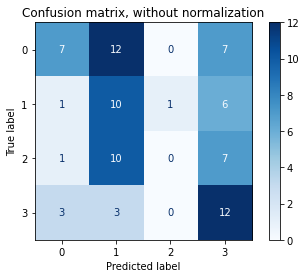

In [245]:
svc_classifier =SVC()
svc_classifier.fit(combined_x_train,y_train)

# Predict
y_pred = svc_classifier.predict(combined_x_test)
titles_options = "Confusion matrix"
disp = plot_confusion_matrix(svc_classifier, combined_x_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize=None)
disp.ax_.set_title(title)
print(title)
print(disp.confusion_matrix)
plt.show()


In [250]:
accuracy_score(y_test, y_pred)

0.3625